# Transfer Learning with TensorFlow - Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: Fine-tuning

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

In [1]:
!python -m wget -O https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


Saved under helper_functions (1).py


In [2]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
%matplotlib inline

> 🔑 **Note:** If you're running this notebook in Google Colab, when time out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want to access your helper functions

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

In [3]:
# Get 10% of training data of 10 classes of Food 101
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')


Saved under 10_food_classes_10_percent.zip


In [4]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [6]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory = train_dir, 
                                                                   image_size = IMG_SIZE,
                                                                   label_mode = 'categorical',
                                                                   batch_size = BATCH_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                       image_size = IMG_SIZE,
                                                       label_mode = 'categorical',
                                                       batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [8]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[114.28571     93.28571     66.28571   ]
   [114.64286     93.64286     66.64286   ]
   [115.28571     94.28571     67.28571   ]
   ...
   [198.64793    208.2194     210.2194    ]
   [196.2857     206.2857     208.2857    ]
   [194.99997    204.99997    206.99997   ]]

  [[120.52551     96.52551     70.52551   ]
   [120.92347     96.92347     70.92347   ]
   [120.92857     96.92857     70.92857   ]
   ...
   [192.42854    202.00002    204.00002   ]
   [191.20918    201.20918    203.20918   ]
   [191.11734    201.11734    203.11734   ]]

  [[122.42857     98.21429     69.78571   ]
   [122.42857     98.21429     69.78571   ]
   [122.64286     98.42857     70.        ]
   ...
   [188.16835    197.73982    199.57146   ]
   [188.80103    198.80103    200.58673   ]
   [189.         199.         200.78572   ]]

  ...

  [[220.64285    220.85712    211.28564   ]
   [223.71431    223.92857    214.3571    ]
   [222.40308    222.95409    213.21425   ]
   ...
   [241.40312    246.403

## Model 0:  Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our model

In [10]:
# 1. Create base model with tf.keras.Applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape =(224,224,3), name='input_layer')

# 4. If using model like ResNet50V2 you will need to normalize inputs (you dont' have to for effnet)
#x = tf.keras.layers.Rescaling(1/255.)(inputs)

# 5. Pass the inputs 
x = base_model(inputs)
print(f'Shape after passing through base model {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D:{x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation ='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. compile the model
model_0.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                       epochs = 5,
                       steps_per_epoch = len(train_data_10_percent),
                       validation_data = test_data,
                       validation_steps = int(0.25 * len(test_data)),
                       callbacks = [create_tensorboard_callback(dir_name ='transfer_learning',
                                                                experiment_name='10_percent_feature_extraction')])

Shape after passing through base model (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210914-201908


D:\Anaconda3\envs\TensorflowTut\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
24/24 [==============================] - 16s 368ms/step - loss: 1.9026 - accuracy: 0.3840 - val_loss: 1.3422 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 7s 285ms/step - loss: 1.1296 - accuracy: 0.7480 - val_loss: 0.9174 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 7s 286ms/step - loss: 0.8337 - accuracy: 0.8147 - val_loss: 0.7714 - val_accuracy: 0.8043
Epoch 4/5
24/24 [==============================] - 7s 284ms/step - loss: 0.6752 - accuracy: 0.8467 - val_loss: 0.6591 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 7s 283ms/step - loss: 0.5822 - accuracy: 0.8587 - val_loss: 0.6193 - val_accuracy: 0.8207


In [11]:
# Evaluate on the full test datset
model_0.evaluate(test_data)

79/79 [==============================] - 13s 156ms/step - loss: 0.6085 - accuracy: 0.8364


[0.6085024476051331, 0.8363999724388123]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [14]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


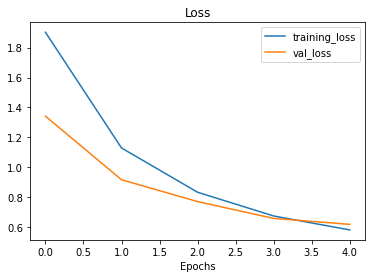

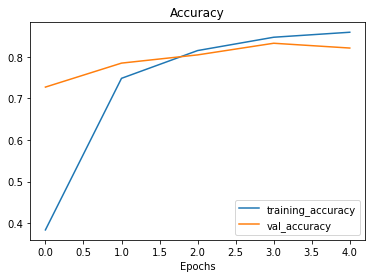

In [15]:
# Check out our model's loss curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)..

But then it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [20]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor: \n {input_tensor} \n')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D Global average pooled random tensor: \n {global_average_pooled_tensor} \n')

# check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D Global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [23]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [27]:
print(f'Random input tensor: \n {input_tensor} \n')

# Pass the random tensor through a global max pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f'2D Global average pooled random tensor: \n {global_average_pooled_tensor} \n')

# check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D Global average pooled random tensor: 
 [[0.9058464 1.1603122 1.6994323]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is, is because what often happens is pretrained models outputs a **feature vector** (a long tensor of numbers which represents the learned representation of a model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can be used to extract patterns out of our own specific problem

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of training data, but how does it go with 1% of the training data ... how about we set up a bunch of experimetns to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation. 

> 🔑 **Note**: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consitency across evaluation metrics. 

### Getting and preprocessing data for model_1

In [33]:
# Download and unzip data 
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

D:\Anaconda3\envs\TensorflowTut\python.exe: No module named O


In [31]:
unzip_data('10_food_classes_1_percent.zip')

In [34]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [35]:
# How many images are we working with?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [37]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(train_dir_1_percent,
                                                                  label_mode = 'categorical',
                                                                  image_size=IMG_SIZE,
                                                                  batch_size=BATCH_SIZE) # default = 32

test_data_1_percent = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 label_mode = 'categorical',
                                                                 image_size= IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow data augmentation documentation.

Off the top of our heads, after reading the documentation, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zoom, etc.
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    #layers.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet is built-in
], name = 'data_augmentation')

### Visualize our data augmentation layer (and see what happens to our data)

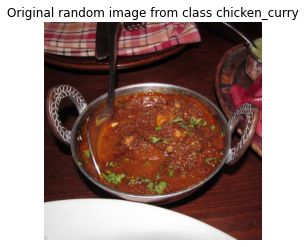

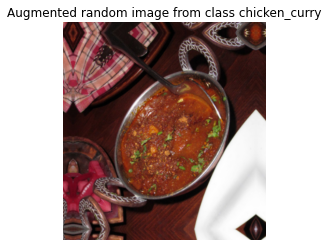

In [60]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class {target_class}')
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'Augmented random image from class {target_class}')
plt.axis(False);

## Model 1 : Feature extraction transfer learning on 1% of the data with data augmentation

In [63]:
# setup the input shape and base model, freezing the base model of layers
input_shape = IMG_SIZE + (3, )
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = 'input_layer')

# add in data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name ='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = 'softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_1_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25 * len(test_data)),
                               # Track model training logs
                               callbacks = [create_tensorboard_callback(dir_name ='transfer_learning',
                                                                        experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210914-223358
Epoch 1/5


D:\Anaconda3\envs\TensorflowTut\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


3/3 [==============================] - 13s 4s/step - loss: 2.3443 - accuracy: 0.1143 - val_loss: 2.2334 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1572 - accuracy: 0.2857 - val_loss: 2.1171 - val_accuracy: 0.2467
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9777 - accuracy: 0.4286 - val_loss: 2.0185 - val_accuracy: 0.2911
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8310 - accuracy: 0.4857 - val_loss: 1.9271 - val_accuracy: 0.3602
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6800 - accuracy: 0.5714 - val_loss: 1.8357 - val_accuracy: 0.3964


In [64]:
# Check out a model summary 
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [67]:
# Evaluate on the full test set
results_1_percent_data_aug = model_1.evaluate(test_data_1_percent)
results_1_percent_data_aug

79/79 [==============================] - 13s 156ms/step - loss: 1.8459 - accuracy: 0.4020


[1.8459242582321167, 0.4020000100135803]

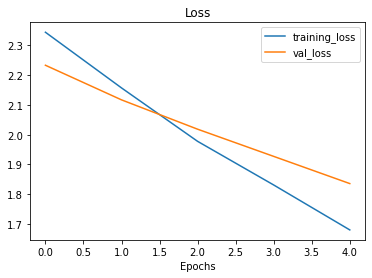

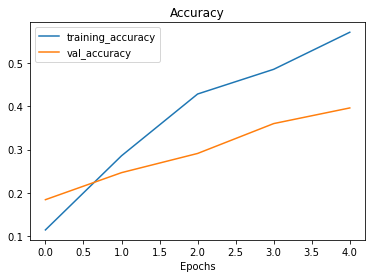

In [68]:
# How do the model with 1% and data aug loss curves look?
plot_loss_curves(history_1_percent)